## Settings

In [1]:
%matplotlib inline
from pathlib import Path
import importlib
from functools import partial

from skimage import color
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns
from bruno_util import plotting as bplt
import scipy
import scipy.stats
from PIL import Image

import multi_locus_analysis as mla
import multi_locus_analysis.examples.burgess as burgess
import multi_locus_analysis.examples.burgess.plotting as mplt
from multi_locus_analysis.examples.burgess.styles import *

use_pnas_style()

from wlcsim.analytical import rouse
from wlcsim.analytical import homolog

In [2]:
import matplotlib.font_manager

In [3]:
matplotlib.font_manager.fontManager = matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [4]:
matplotlib.font_manager.findfont('Arial')

'/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'

### Output settings


In [7]:
output_folder = (Path(mla.__file__).parent / Path('../doc/source/_static/homologs/')).resolve()
output_folder

PosixPath('/home/bbeltr1/developer/multi_locus_analysis/doc/source/_static/homologs')

get font sizes to use in Inkscape

In [6]:
plt.plot()
xl = plt.xlabel('test')
titl = plt.title('test')
print("Label font size: " + str(xl.get_font_properties().get_size_in_points()) + "pts")
print("Title font size: " + str(titl.get_font_properties().get_size_in_points()) + "pts")
plt.close()

Label font size: 9.6pts
Title font size: 11.52pts


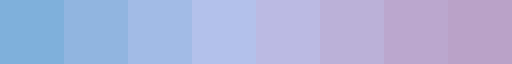

In [7]:
sim_listed_cmap

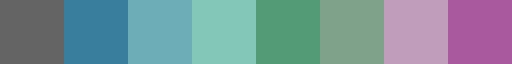

In [8]:
long_listed_cmap

### Functions used in multiple plots

In [8]:
def plot_fracs_small(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            try:
                data = fracs.loc[strain, genotype]
            except:
                continue
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 4  # if strain == 'LYS2' else 4
            markeredgewidth = 1.5 if strain == 'LYS2' else 1
            
            if ax is None:
                ax = plt
            genotype = genotype if genotype == 'WT' else r'$\mathit{spo11}\Delta{}$'
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=1, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  
    
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            try:
                data = fracs.loc[strain, genotype]
            except:
                continue
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
            markersize = 6  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            genotype = genotype if genotype == 'WT' else r'$\mathit{spo11}\Delta{}$'

            if ax is None:
                ax = plt
            non_g0 = data[data['t'] >= 0]
            ax.errorbar(non_g0['t'], non_g0['mean'], non_g0['std']/np.sqrt(non_g0['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
            g0 = data[data['t'] < 0]
            ax.errorbar(g0['t'], g0['mean'], g0['std']/np.sqrt(g0['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker)
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)


## Figure 1

In [10]:
# ### PANEL A
# def fig1a(ax1a):
#     im = Image.open("extracted-progression-diagram.png")
#     ax1a.imshow(im)
#     ax1a.axis('off')
#     ax1a.text(0.270, 1, "Early", fontsize=mpl.rcParams['axes.titlesize'], color=color_early, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.577, 1, "Mid", fontsize=mpl.rcParams['axes.titlesize'], color=color_mid, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.892, 1, "Late", fontsize=mpl.rcParams['axes.titlesize'], color=color_late, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     return ax1a

### PANEL B

def fig1d(ax1d):
    # make background image with various colors
    color_list = cmap_long(long_cnorm_continuous(np.linspace(0, 5, 1000)))
    color_list[:,3] = 0.9 # alpha value
    background_img = np.tile(color_list, (2, 1, 1)).T.T

    # get data about meiotic progression extracted from Trent's figure
    df_trent = pd.read_csv('pnas_data/extracted-progression-data.csv')
    t04 = np.arange(0, 5)
    frac_nuc = df_trent['Unnamed: 1'].iloc[1:].values.astype(float)
    # Sean wanted these removed, we no longer talk about SC
#     t2p5 = np.arange(2.5, 5)
#     frac_sc = df_trent['Unnamed: 3'].iloc[1:4].values.astype(float)
    t35 = np.arange(3, 6)
    frac_mi = df_trent['Unnamed: 5'].iloc[1:4].values.astype(float)
    # make lines
    ax1d.plot(t04, frac_nuc/100, c='k', marker='o', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
#     ax1d.plot(t2p5, frac_sc/100, c='k', marker='X', markersize=8, markeredgewidth=1,
#              fillstyle='full', linestyle='-', lw=1.5, clip_on=False)
    ax1d.plot(t35, frac_mi/100, c='k', marker='s', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
    # make text overlay
    dna_rep_time = [0.3, 1.5]
    dna_rep_y = 0.78
    dna_rep_cap_width = 0.03
    dna_rep_cap_y = [dna_rep_y - dna_rep_cap_width, dna_rep_y + dna_rep_cap_width]
    ax1d.plot(dna_rep_time, [dna_rep_y, dna_rep_y], color='k', linestyle='-', lw=1.5)
    ax1d.plot([dna_rep_time[0], dna_rep_time[0]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
    ax1d.plot([dna_rep_time[1], dna_rep_time[1]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
#     ax1d.text(np.mean(dna_rep_time)+0.02, 0.84, 'DNA Replication', ha='center', va='bottom')
    ax1d.text(dna_rep_time[0]-0.02, 0.84, 'DNA Replication', ha='left', va='bottom')
    ax1d.text(2.4, 0.7, 'Colocalization', ha='center', va='top')
#     ax1d.text(2.7, 0.36, 'SC', ha='center', va='top')
    ax1d.text(3.62, 0.3, 'Meiosis I', ha='right', va='top')

    ax1d.imshow(background_img, extent=[0, 5, 0, 1], aspect='auto')
    ax1d.set_xlim([0, 5])
    ax1d.set_ylim([0, 1])
    ax1d.xaxis.set_major_formatter(long_formatter)
    ax1d.xaxis.set_major_locator(long_locator)

    ax1d.set_xlabel('Chronological stage')
    ax1d.set_ylabel('Probability')
    ax1d.set_title('Meiotic prophase')
    return ax1d


take out SC curve, add description stating that before t3, no division occurs.

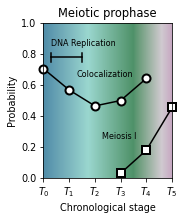

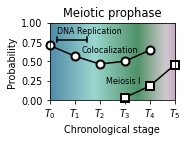

In [11]:
# this panel only gets part of the column, 2.305in measured in inkscape

fig1dh, fig1d_height = bplt.make_at_aspect([fig1d], [1/golden_ratio], halign=['full'], col_width=2.305)
plt.savefig(output_folder / Path('Fig1d.pdf'), dpi=500)
plt.savefig(output_folder / Path('Fig1d.svg'), dpi=500)


## Figure 2

Made fully in Inkscape.... :/

In [12]:
from IPython.core.display import SVG
SVG(filename='./_static/homologs/Fig2.svg')

## Figure 3

Made fully in Inkscape.... :/

In [13]:
from IPython.core.display import SVG
SVG(filename='./_static/homologs/Fig3.svg')

## Figure 4

In [29]:
mu_fig4 = 2
N_cells_fig4 = 5
cells = np.array([
    homolog.generate_poisson_homologs(mu_fig4, burgess.chrv_size_nuc_chain_um) 
    for i in range(N_cells_fig4)
], dtype=object)
plateaus = [
    homolog.mscd_plateau(
        cell, 
        label_loc=burgess.location_ura_nuc_chain_um, 
        chr_size=burgess.chrv_size_nuc_chain_um, 
        nuc_radius=burgess.nuc_radius_um,
        b=burgess.kuhn_length_nuc_chain
    ) for cell in cells
]
i = np.argsort(plateaus)
cells = cells[i]
cells

array([array([4.00044779, 6.38559177]),
       array([ 3.46619986,  7.66469035, 10.98767922, 13.23652351, 13.69979137,
       14.66968967]),
       array([ 2.58970534, 11.15891377]),
       array([ 1.53397148, 12.5348612 , 14.76449493, 15.0488709 ]),
       array([], dtype=float64)], dtype=object)

In [30]:
def fig4a(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.title('Per-Cell MSCDs for Condition: (URA3, WT, t3)')
    ax.set_prop_cycle(color=['#aec7e8'])
    cell_ids = []
    for i, (cell_id, data) in enumerate(free_mscds3.groupby(['exp.rep', 'cell'])):
        if i % 20 != 0:
                continue
        cell_ids.append(cell_id)
        data = data.reset_index()
        data = data[(data['delta'] > 0) & (data['mean'] > 0)]
        data = data.sort_values('delta')
        if cell_id == (5, 56):
            ax.plot(data['delta'], data['mean'], '-', c='#1f77b4', lw=5, zorder=3)
        else:
            ax.plot(data['delta'], data['mean'], alpha=1, lw=1)
            ax.plot(data['delta'], data['mean'], alpha=0.3, lw=3)
    bplt.draw_power_law_triangle(ax=ax, alpha=0, x0=[30, 1.05], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
    bplt.draw_power_law_triangle(ax=ax, alpha=0.5, x0=[225, 0.37], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0.5$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
    ylim = [0.2, 3]
    ax.set_ylim(ylim)
    tick_loc = get_sean_ticks(ylim)
    ax.set_yticks(tick_loc)
    labels = label_sean_ticks(tick_loc, ax)
    ax.set_yticklabels(labels)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    ax.get_yaxis().set_label_coords(-0.17, 0.5)
    return ax

def fig4b(ax):
    t = np.logspace(-1, np.log10(1500), 50).astype(float)
    for i, linkages in enumerate(cells):
        mscd = homolog.mscd(
            t, linkages, 
            label_loc=burgess.location_ura_nuc_chain_um, 
            chr_size=burgess.chrv_size_nuc_chain_um, 
            nuc_radius=burgess.nuc_radius_um,
            b=burgess.kuhn_length_nuc_chain, 
            D=burgess.sim_D
        )
        lines = ax.loglog(t, mscd, c=cycling_cmap.colors[i])
        ax.annotate('Cell ' + str(i), [t[-1], mscd[-1]], va='bottom', ha='right', 
                    c=cycling_cmap.colors[i], fontsize=mpl.rcParams['axes.titlesize'])
    ylim = [0.02, 3]
    ax.set_ylim(ylim)
    tick_loc = get_sean_ticks(ylim)    
    ax.set_yticks(tick_loc)
    labels = label_sean_ticks(tick_loc, ax)
    ax.set_yticklabels(labels)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)') #, labelpad=-float(mpl.rcParams['font.size']))
    ax.get_yaxis().set_label_coords(-0.17, 0.5)
    
    return ax

def fig4c(ax):
    return mplt.draw_cells(
        cells, ax=ax, 
        label_loc=burgess.location_ura_nuc_chain_um,
        cen_loc=burgess.location_cen5_nuc_chain_um,
        chr_size=burgess.chrv_size_nuc_chain_um,
        label_colors=cycling_cmap.colors[:len(cells)]
    )

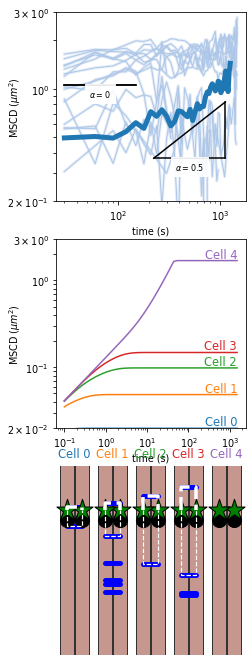

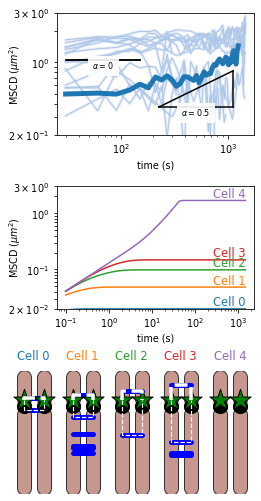

In [31]:
free_group3 = burgess.df_flat.loc['URA3', 'WT', :, 't3'].copy()

free_mscds3 = burgess.msds.msd(free_group3[free_group3['foci'] == 'unp'], mscd=True, include_z=True, 
                              traj_group=['exp.rep', 'cell'],
                              groups=['exp.rep', 'cell'])
fig4, fig4_heights = bplt.make_at_aspect(
    [fig4a, fig4b, fig4c], [1/golden_ratio, 1/golden_ratio, 1/2], col_width, 
    tight_width='bbox', halign=['min_axis_width', 'min_axis_width', 'full'], 
    hspace=0.15, is_ratio=True)

plt.savefig(output_folder / Path('Fig4.svg'))

## Figure 5

after running the following, they must still be assembled in inkscape and the labels of the arrows must still be added (by copying over the appropriate colorbar tick labels to label the arrows with)

### Fitting Diffusivity

Load experimental MSCDs, and use weighted average to get plateau value.

In [10]:
strains_for_plateau = [(locus, strain) for locus in ['URA3', 'LYS2'] for strain in ['WT', 'SP']]
msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
        .set_index(['locus', 'genotype', 'meiosis'])
def average_end_times(df):
    df = df.set_index('delta')
    weights = df['ste'] / np.sum(df['ste'])
    weights = weights.loc[810:] / np.sum(weights.loc[800:])
    return np.sum(df.loc[810:, 'mean']*weights)
plateaus = pd.DataFrame(index=[f't{i}' for i in range(7)])
for strain in strains_for_plateau:
    d = mscds.loc[strain]
    averages = d.groupby('meiosis').apply(average_end_times)
    plateaus[strain] = averages.loc['t0':'t6']
 

Compute analytical plateau values from our theory for various linkage densities.

In [11]:
importlib.reload(homolog)

<module 'wlcsim.analytical.homolog' from '/home/bbeltr1/developer/wlcsim/wlcsim/analytical/homolog.py'>

In [12]:
mus = np.linspace(0, 10, 100)
N_cells = 1000

theory_plateaus_ura = np.zeros_like(mus)
for i, mu in enumerate(mus):
    for j in range(N_cells):
        theory_plateaus_ura[i] += (1/N_cells) * homolog.mscd_plateau(
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um),
            label_loc=burgess.location_ura_nuc_chain_um,
            chr_size=burgess.chrv_size_nuc_chain_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain
        )

theory_plateaus_lys = np.zeros_like(mus)
for i, mu in enumerate(mus):
    for j in range(N_cells):
        theory_plateaus_lys[i] += (1/N_cells) * homolog.mscd_plateau(
            homolog.generate_poisson_homologs(mu, chr_size=burgess.chrii_linker_um),
            label_loc=burgess.location_lys_nuc_chain_um,
            chr_size=burgess.chrii_linker_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain
        )


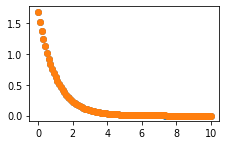

In [13]:
analytical_plateaus_lys = np.array([homolog.mscd_plateau_ensemble(
        mu, label_loc=burgess.location_lys_nuc_chain_um,
        L=burgess.chrii_linker_um,
        nuc_radius=burgess.nuc_radius_um,
        b=burgess.kuhn_length_nuc_chain
) for mu in mus])
analytical_plateaus_ura = np.array([homolog.mscd_plateau_ensemble(
        mu, label_loc=burgess.location_ura_nuc_chain_um,
        L=burgess.chrv_linker_um,
        nuc_radius=burgess.nuc_radius_um,
        b=burgess.kuhn_length_nuc_chain
) for mu in mus])
# plt.scatter(mus, analytical_plateaus_ura, c='b', marker='o', label=r'$\mathit{URA3}$')
# plt.scatter(mus, analytical_plateaus_lys, c='k', marker='x', label=r'$\mathit{LYS2}$')
plt.scatter(mus, analytical_plateaus_ura, label=r'$\mathit{URA3}$')
plt.scatter(mus, analytical_plateaus_lys, label=r'$\mathit{LYS2}$')

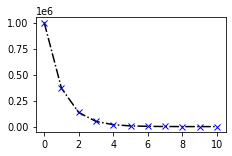

In [19]:
mus_test = np.linspace(0, 10, 11)
L1 = 10
label1 = 5
L2 = 1000
label2 = 5
b = 1
nuc_radius = 1000
p1 = np.array([homolog.mscd_plateau_ensemble(
        mu, label1, L1, b, nuc_radius
) for mu in mus_test])
p2 = np.array([homolog.mscd_plateau_ensemble(
        mu, label2, L2, b, nuc_radius
) for mu in mus_test])
plt.plot(mus_test, p1, 'k-.')
plt.plot(mus_test, p2, 'bx')

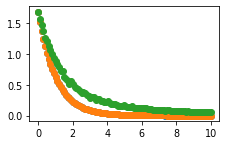

In [14]:
plt.scatter(mus, analytical_plateaus_ura, label=r'$\mathit{URA3}$')
plt.scatter(mus, analytical_plateaus_lys, label=r'$\mathit{LYS2}$')
plt.scatter(mus, theory_plateaus_ura)

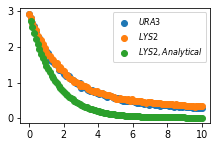

In [15]:
slope = 0.686798088540447
intercept = 2.189713913621381
plateau_observed_ura = 10**(slope*np.log10(theory_plateaus_ura*1000**2) + intercept) / 1000**2
plateau_observed_lys = 10**(slope*np.log10(theory_plateaus_lys*1000**2) + intercept) / 1000**2
plateau_obsa_lys = 10**(slope*np.log10(analytical_plateaus_lys*1000**2) + intercept) / 1000**2


plt.scatter(mus, plateau_observed_ura, label=r'$\mathit{URA3}$')
plt.scatter(mus, plateau_observed_lys, label=r'$\mathit{LYS2}$')
plt.legend()

In [31]:
plateaus

,"(URA3, WT)","(URA3, SP)","(LYS2, WT)","(LYS2, SP)"
t0,1.044415,1.010991,1.084440,1.142015
t1,1.260647,1.177359,1.158803,1.049608
t2,1.444618,1.339852,1.307054,1.310318
t3,1.474734,1.500458,1.266264,1.319391
t4,1.355521,1.511157,1.155973,1.334972
t5,1.097315,1.315964,1.206607,1.316077
t6,NaN,1.440014,1.154246,1.349525


In [32]:
fit_mu_ura = plateaus[[('URA3', 'WT'), ('URA3', 'SP')]] \
        .applymap(lambda p: np.interp(p, plateau_observed_ura[::-1], mus[::-1]))

In [33]:
fit_mu_ura

,"(URA3, WT)","(URA3, SP)"
t0,2.728129,2.752684
t1,2.131662,2.329316
t2,1.684584,1.853702
t3,1.497378,1.469992
t4,1.835434,1.458601
t5,2.420728,1.881551
t6,NaN,1.703101


In [34]:
fit_mu_lys = plateaus[[('LYS2', 'WT'), ('LYS2', 'SP')]] \
        .applymap(lambda p: np.interp(p, plateau_observed_ura[::-1], mus[::-1]))

In [35]:
fit_mu_lys

,"(LYS2, WT)","(LYS2, SP)"
t0,2.449217,2.369679
t1,2.350507,2.582074
t2,1.891938,1.888132
t3,2.125281,1.877555
t4,2.353740,1.859390
t5,2.193046,1.881419
t6,2.355712,1.842424


In [ ]:
theory_mscds = np.zeros_like(t_data)
for j in range(N_cells):
    linkages = homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um)
    theory_mscds += (1/N_cells) * homolog.mscd(
        t_data,
        linkages=linkages,
        label_loc=burgess.location_ura_nuc_chain_um,
        chr_size=burgess.chrv_size_nuc_chain_um,
        nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
        D=D*np.random.exponential()
    )


In [118]:
   
mscd_ura_t3 = mscds.loc['URA3', 'WT', 't3'].sort_values('delta')
plateau = plateaus[('URA3', 'WT')]['t3']
mu = fit_mus[('URA3', 'WT')]['t3']
theory_plateau = np.interp(mu, mus, theory_plateaus)
theory_observed = np.interp(mu, mus, plateau_observed)
rescaling = theory_observed / theory_plateau
t_data = burgess.t_data[:-1]  # mscd 'delta' only up to 1470

def theory_mscds_compared(D, N_cells=100):
    theory_mscds = np.zeros_like(t_data)
    for j in range(N_cells):
        linkages = homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um)
        theory_mscds += (1/N_cells) * homolog.mscd(
            t_data,
            linkages=linkages,
            label_loc=burgess.location_ura_nuc_chain_um,
            chr_size=burgess.chrv_size_nuc_chain_um,
            nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
            D=D*np.random.exponential()
        )
    theory_mscds = theory_mscds * rescaling
    return theory_mscds

def compare_to_ura3(logD, N_cells=100):
    D = 10**logD
    theory_mscds = theory_mscds_compared(D, N_cells)
    return -np.linalg.norm(theory_mscds - mscd_ura_t3['mean'])

NameError: name 'mscds' is not defined

In [20]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'logD': (-1, 1)}

optimizer = BayesianOptimization(
    f=compare_to_ura3,
    pbounds=pbounds,
    random_state=1,
)

In [21]:
optimizer.maximize(
    init_points=5,
    n_iter=5,
)

|   iter    |  target   |   logD    |
-------------------------------------
|  1        | -1.712    | -0.166    |
|  2        | -0.1982   |  0.4406   |
|  3        | -4.564    | -0.9998   |
|  4        | -3.388    | -0.3953   |
|  5        | -3.659    | -0.7065   |
|  6        | -0.2628   |  0.8657   |
|  7        | -1.539    |  0.1757   |
|  8        | -0.6851   |  0.1756   |
|  9        | -0.7958   |  0.8655   |
|  10       | -0.6505   |  0.1753   |


In [22]:
def plot_bayes_opt(f, optimizer):
    x = np.linspace(-1, 1, 1000)
    mean, sigma = optimizer._gp.predict(x.reshape(-1, 1), return_std=True)
    plt.plot(10**x, -mean)
    plt.fill_between(10**x, -(mean + sigma), -(mean - sigma), alpha=0.1)
    plt.scatter(10**optimizer.space.params.flatten(), -optimizer.space.target, c="red", s=50, zorder=10)
    plt.yscale('log')
    plt.xlabel('D ($\mu{}m^2$)')
    plt.ylabel('$||$ Theory -- Experiment $||^2$')

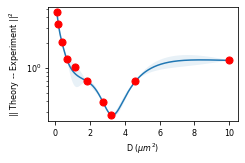

In [26]:
plot_bayes_opt(compare_to_ura3, optimizer)
plt.savefig('./_static/homologs/SuppFig_D-fit_a.svg')

In [25]:
Ds = 10**optimizer.space.params.flatten()
i = np.argsort(Ds)
err = -optimizer.space.target


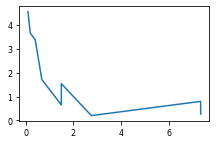

In [28]:
plt.plot(Ds[i], err[i])

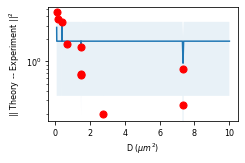

In [23]:

plot_bayes_opt(compare_to_ura3, optimizer)
plt.savefig('./_static/homologs/SuppFig_D-fit_a.svg')

In [106]:
optimizer.set_bounds(new_bounds={'logD': [np.log10(2), np.log10(5)]})
optimizer.maximize(n_iter=100)

|   iter    |  target   |   logD    |
-------------------------------------
|  11       | -0.2136   |  0.3566   |
|  12       | -0.209    |  0.4132   |
|  13       | -0.1643   |  0.5091   |
|  14       | -0.131    |  0.5399   |
|  15       | -0.1669   |  0.6254   |
|  16       | -0.1796   |  0.5373   |
|  17       | -0.2042   |  0.8955   |
|  18       | -0.332    |  0.301    |
|  19       | -0.1931   |  0.7827   |
|  20       | -0.1945   |  0.7772   |
|  21       | -0.1726   |  0.7416   |
|  22       | -0.1816   |  0.5163   |
|  23       | -0.1594   |  0.6782   |
|  24       | -0.1586   |  0.6331   |
|  25       | -0.1721   |  0.6412   |
|  26       | -0.1781   |  0.5252   |
|  27       | -0.1501   |  0.5484   |
|  28       | -0.2163   |  0.5566   |
|  29       | -0.1642   |  0.7262   |
|  30       | -0.1628   |  0.7179   |
|  31       | -0.1892   |  0.7096   |
|  32       | -0.1641   |  0.6866   |
|  33       | -0.1613   |  0.6952   |
|  34       | -0.1536   |  0.7022   |
|  35       

In [33]:
import wlcsim

In [34]:
wlcsim.__version__

'0.1.8'

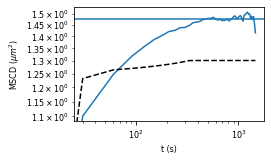

In [63]:
best_D = 10**optimizer.max['params']['logD']
theory_mscds = theory_mscds_compared(best_D*10, N_cells=100)

plt.loglog(mscd_ura_t3['delta'], mscd_ura_t3['mean'])
plt.loglog(t_data, theory_mscds, 'k--')
plt.axhline(plateau)
plt.xlabel('t (s)')
plt.ylabel('MSCD ($\mu{}m^2$)')
plt.savefig('./_static/homologs/SuppFig_D-fit_b.svg')

### Actually making the plots

In [80]:
ymax = 1.5

def fig5ac(ax, strain=('URA3', 'WT'), arrows=True):
    msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
    if not msds_file.exists():
        burgess.msds.precompute_msds()
    mscds = pd.read_csv(msds_file) \
            .set_index(['locus', 'genotype', 'meiosis'])

    d = mscds.loc[strain]

#     fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')

    ## draw all the MSCDs
    thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
    lines = {}
    for meiosis, data in d.groupby('meiosis'):
        t = -1 if meiosis[1] == 'a' else int(meiosis[1])
        data = data[data['delta'] > 0]
        zorder = 1.5 if t < 0 else 2  # 2 is default
        linewidth = 2 if t in thick_lines else 1
        alpha = 0.8 if t < 0 else 1
        lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
                                      c=long_listed_cmap(long_cnorm(t)), zorder=zorder,
                                      alpha=alpha, lw=linewidth)
    #     bplt.draw_power_law_triangle(alpha=0.2, x0=[100, 0.5], width=0.7, orientation='down', x0_logscale=False, label=r'$\alpha=0.2$', label_padding=0.02)
    ax.set_ylim([0.5, ymax])
    ax.set_xlim(ax.get_xlim())  # default is good, but needs stay fixed

    ## draw the two arrows
    if arrows:
        # in data coordinates
        x1, y1 = 30, 0.61
        x2, y2 = 50, 1
        # in axes coordinates, to avoid bad log scaling
        data_to_ax = ax.transData + ax.transAxes.inverted()
        X1_ax = data_to_ax.transform([x1, y1])
        X2_ax = data_to_ax.transform([x2, y2])
        dX21_ax = X2_ax - X1_ax
        ax.arrow(*X1_ax, *dX21_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)
        X3_ax = X2_ax + np.array([0.05, 0.05])
        x4, y4 = 84, 0.9
        X4_ax = data_to_ax.transform([x4, y4])
        X4_ax_alt = X3_ax + dX21_ax*np.array([1, -1])  # to get same x offset
        dX43_ax = X4_ax - X3_ax
        ax.arrow(*X3_ax, *dX43_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)

    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    # plt.savefig("/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-01-28-proposed/mscd-" + str(strain) + "-with-cbar-short.pdf")


    ## ticks, labels, etc
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ymax])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", f"${ymax}" + r"\times{}10^{0}$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

def fig5b(ax):
    mus = np.arange(7)
    t = np.arange(0, 1500, 30)
    N_cells = 100
    for mu in mus:
        mscd = np.zeros_like(t).astype(float)
        for i in range(N_cells):
            mscd += (1/N_cells) * homolog.mscd(
                t_data,
                homolog.generate_poisson_homologs(mu, chr_size=burgess.chrv_size_nuc_chain_um),
                label_loc=burgess.location_ura_nuc_chain_um,
                chr_size=burgess.chrv_size_nuc_chain_um,
                nuc_radius=burgess.nuc_radius_um, b=burgess.kuhn_length_nuc_chain,
                D=burgess.sim_D*np.random.exponential()
            )
        theory_plateau = np.interp(mu, mus, theory_plateaus)
        theory_observed = np.interp(mu, mus, plateau_observed)
        rescaling = theory_observed / theory_plateau    
        plt.loglog(t, rescaling*mscd, c=sim_listed_cmap(sim_cnorm(mu)))
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    cb.set_label('Connections per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10, 10**4])
    ax.set_ylim([0.5, 1.5])    
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, ymax])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", f"${ymax}" + r"\times{}10^{0}$"])
#     ax.set_ylim([0.2, 3.5])
#     ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3.])
#     ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", ""])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

make two plots: 
1) as is, data
2) chronological stage vs num-linkages fit

In [142]:
# # twin version rejected by Sean
# def fig4d_twin(ax):
#     wt = plateaus[(locus, 'WT')]
#     sp = plateaus[(locus, 'SP')]
#     ax.plot(np.arange(len(wt)), wt.values, c=cycling_cmap(1))
#     ax.plot(np.arange(len(sp)), sp.values, c=cycling_cmap(0))
#     ax.set_xlabel('Chronological stage')
#     ax.set_ylim([0.5, 2])
#     ax2 = ax.twiny()
#     ax2.plot(andy_links, andy_plats, c='k')
#     ax2.set_xlabel('Number of linkages')
#     ax2.set_xlim([1, 5])
def fig5c_with_triangle(ax):
    fig5ac(ax, strain=('URA3', 'SP'), arrows=False)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.27), 0.5, orientation='down', ax=ax, label=None)
    return ax

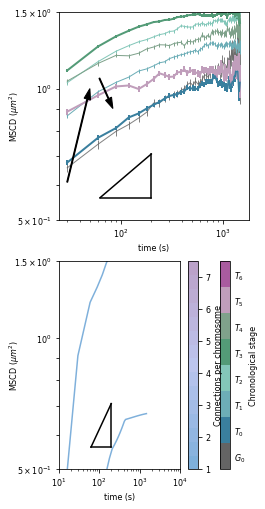

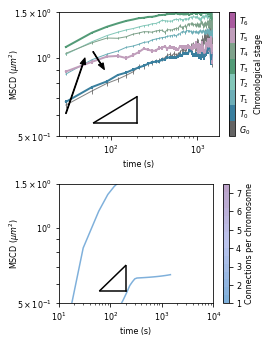

In [81]:
def fig5a_with_triangle(ax):
    fig5ac(ax, strain=('URA3', 'WT'))
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
def fig5b_with_triangle(ax):    
    fig5b(ax)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
bplt.make_at_aspect(
        [fig5a_with_triangle, fig5b_with_triangle], 
        [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
plt.savefig(output_folder / Path('Fig5ab.svg'))

In [138]:
fit_mus = plateaus.applymap(lambda p: np.interp(p, plateau_observed[::-1], mus[::-1]))
fit_mus = fit_mus.stack().reset_index()
fit_mus['locus'] = fit_mus['level_1'].apply(lambda x: x[0])
fit_mus['genotype'] = fit_mus['level_1'].apply(lambda x: x[1])
fit_mus['meiosis'] = fit_mus['level_0']
fit_mus['mu'] = fit_mus[0]
fit_mus = fit_mus[['locus', 'genotype', 'meiosis', 'mu']].set_index(['locus', 'genotype', 'meiosis']).sort_index()

In [137]:
fit_mus

mean
locus genotype meiosis          
URA3  SP       t0       2.388315
               t1       1.860355
               t2       1.508157
               t3       1.355149
               t4       1.335980
               t5       1.653404
               t6       1.421149
      WT       t0       2.216300
               t1       1.765597
               t2       1.423152
               t3       1.373346
               t4       1.506670
               t5       2.163812

In [143]:
def fig5d(ax):
    fit_mus['mean'] = fit_mus['mu']
    fit_mus['cell_count'] = np.nan
    fit_mus['std'] = np.nan
    plot_fracs_large(fit_mus, ax)
    ax.set_ylabel('Average linkages per chromosome')
    ax.legend(fontsize='small')
    return ax

/home/bbeltr1/.miniconda3/envs/btest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/bbeltr1/.miniconda3/envs/btest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/bbeltr1/.miniconda3/envs/btest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/bbeltr1/.miniconda3/envs/btest/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


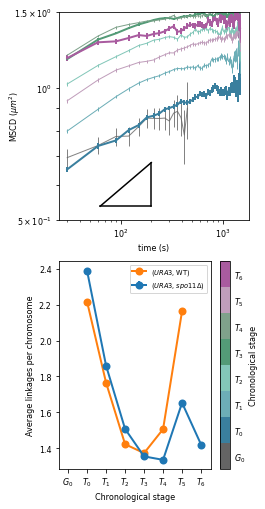

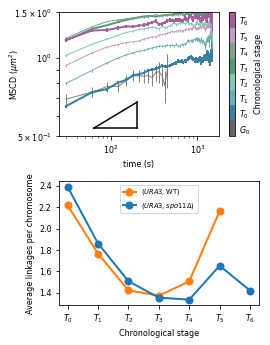

In [144]:
    
bplt.make_at_aspect(
        [fig5c_with_triangle, fig5d], 
        [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['min_axis_width', 'min_axis_width'],
        is_ratio=True)
plt.savefig(output_folder / Path('Fig5cd.svg'))

## Figure 6

In [12]:
def fig6a(ax):
    pair_fracs = (burgess.df_flat['foci'] == 'pair').groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
#     cells_per_state = burgess.df_flat.reset_index().groupby(burgess.condition_cols)['cell'].unique().apply(len)
    pair_fracs['cell_count'] = pair_fracs['count']
    plot_fracs_large(pair_fracs, ax)
    ax.set_ylabel('Fraction of time colocalized')
    ax.legend(fontsize='small')
    return ax
  
def fig6b(ax):
    is_mixed = burgess.df_flat['foci'].groupby(burgess.cell_cols).apply(lambda x: np.any(x == 'pair') and np.any(x == 'unp'))
    mixed_fracs = is_mixed.groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
    cells_per_state = burgess.df_flat.reset_index().groupby(burgess.condition_cols)['cell'].unique().apply(len)
    mixed_fracs['cell_count'] = cells_per_state
    plot_fracs_large(mixed_fracs, ax)
    ax.legend(fontsize='small')
    ax.set_ylabel('Fraction mixed')
    ax.set_ylim([0.15, 0.95])
    return ax
    
    

In [24]:
burgess.df_flat.reset_index().groupby(burgess.condition_cols)['exp.rep'].unique().reset_index().to_csv('C:/Users/bbeltr1/Downloads/tmp.csv', index=False)

In [17]:
burgess.df_flat.groupby(burgess.condition_cols)['exp.rep'].first()

KeyError: 'Column not found: exp.rep'

In [29]:
fold = Path(burgess.__file__).parent

In [33]:
list(fold.iterdir())

[WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/all_vvc.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/analysis.py'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/confinements-v1-meh.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/cvv_fits.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/cvv_stats.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/cvv_stats_cond.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/df.csv'),
 WindowsPath('c:/users/bbeltr1/pycharmprojects/multi_locus_analysis/multi_locus_analysis/examples/burgess/df_flat.csv'),
 WindowsPath('c

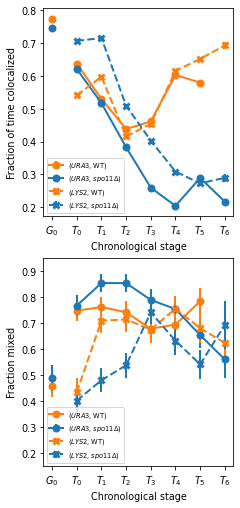

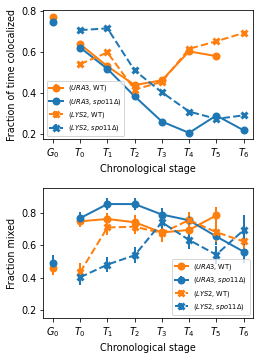

In [13]:
fig6ab, fig6ab_heights = bplt.make_at_aspect([fig6a, fig6b], [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'min_axis_width'],
        is_ratio=True)
plt.savefig(output_folder / Path('Fig6ab.svg'))
# plt.savefig('/home/bbeltr1/developer/multi_locus_analysis/doc/source/pnas_data/Fig6ab.pdf')

## Figure 7

TODO: fix line coloring and ordering, currently done in inkscape...

In [9]:
# sim_df = pd.read_csv(Path('pnas_data/df_exp.csv'))
# sim_df['t'] = np.round(sim_df['t']/30).astype(int)*30
# for x in ['X', 'Y', 'Z']:
#     sim_df['d'+x] = sim_df[x+'2'] - sim_df[x+'1']
# wait_sim = burgess.simulation.get_interior_times(sim_df, state_col='pair250')
# wait_sim = wait_sim.reset_index()
# # wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < 0.2)]
# wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < vmax_sim)]

waitdf = burgess.df_flat.groupby(burgess.cell_cols + ['na_id']).apply(mla.finite_window.discrete_trajectory_to_wait_times, t_col='t', state_col='foci')
waitdf.dropna(inplace=True) # get rid of NaN waits (currently buggy window sizes)
interior_df = waitdf.groupby(burgess.cell_cols + ['na_id']).apply(
    lambda df: df.iloc[1:-1].reset_index(level='rank_order').reset_index(drop=True).set_index('rank_order'))
interior_df.sort_index(inplace=True)
pair_df = interior_df[interior_df['wait_state'] == 'pair']
unpair_df = interior_df[interior_df['wait_state'] == 'unp']

KeyError: 'wait_state'

In [121]:
def fig7cdef(ax, strain=('LYS2', 'WT'), pair='pair'):
    df = pair_df if pair == 'pair' else unpair_df
    state_waits = df.loc[strain]
    bold_lines = [0, 6] if 't6' in state_waits.reset_index()['meiosis'] else [0, 5]
    print(bold_lines)
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t in bold_lines:
            continue
        alpha = 0.5
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, alpha=alpha)
    # make sure bold lines are on top
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t not in bold_lines:
            continue
        print(f'found bold line: {m}')
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, lw=2)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    ax.set_yscale('log')
    ax.set_xscale('log')
    pair = 'Residence times' if pair == 'pair' else 'Search times'
    strain = 'wild-type' if strain[1] == 'WT' else r'\mathit{spo11$\Delta$}'
    ax.set_title(f"{pair}, {strain} PDFs")
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    return ax

def fig7a(ax):
    fp_targets = np.linspace(0.01, 0.02, 5)
    
    # some convenience variables
    paired_sim = wait_sim[wait_sim['wait_state']]
    paired_1 = paired_sim[paired_sim['FP'] == 0.01]
    paired_2 = paired_sim[paired_sim['FP'] == 0.02]
    unpaired_sim = wait_sim[~wait_sim['wait_state']]
    unpaired_1 = unpaired_sim[unpaired_sim['FP'] == 0.01]
    unpaired_2 = unpaired_sim[unpaired_sim['FP'] == 0.02]

    boot_N = 400
    fp01_options = paired_1.sim_name.unique()
    fp02_options = paired_2.sim_name.unique()

    paired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    unpaired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    for fp in fp_targets:
        frac_02 = (fp - 0.01)/(0.02 - 0.01)
        for i in range(boot_N):
            if np.random.rand() < frac_02:
                traj_name = np.random.choice(fp02_options)
                pwaits = paired_2[paired_2['sim_name'] == traj_name]
                upwaits = unpaired_2[unpaired_2['sim_name'] == traj_name]
            else:
                traj_name = np.random.choice(fp01_options)
                pwaits = paired_1[paired_1['sim_name'] == traj_name]
                upwaits = unpaired_1[unpaired_1['sim_name'] == traj_name]
            paired_waits[fp] = paired_waits[fp].append(pwaits)
            unpaired_waits[fp] = unpaired_waits[fp].append(upwaits)

    # bootstrapped ones
    for FP, paired in paired_waits.items():
        if FP > vmax_sim:
            continue
        if FP == 0.01:
            continue
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP))
    # true simulations
    for FP, data in wait_sim.groupby('FP'):
        if FP in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):
        if FP not in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    # plt.legend()
    ax.set_title('Residence times, simulation PDFs')
#     ax.set_ylim([2e-6, 4e-2])
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])

    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

def fig7b(ax):
    for FP, data in wait_sim.groupby('FP'):       
        if FP in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):        
        if FP not in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    # plt.legend()
    ax.set_title('Search time, simulation PDFs')
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

new arrangement, pretty voluminous

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


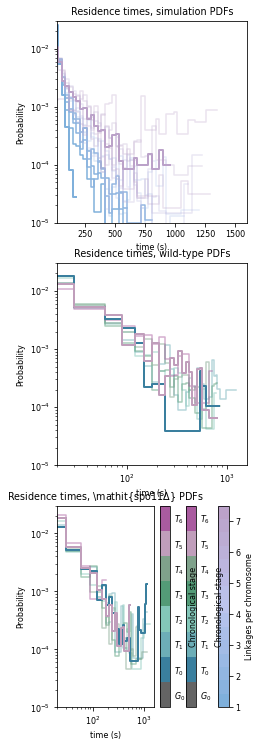

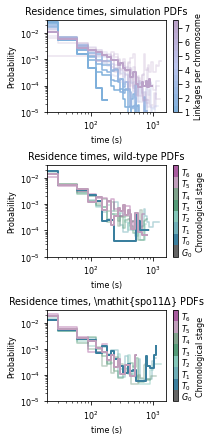

In [124]:
fig7ace, fig7ace_heights = bplt.make_at_aspect(
    [fig7a,
     partial(fig7cdef, strain=('HET5', 'WT'), pair='pair'), 
     partial(fig7cdef, strain=('HET5', 'WT'), pair='unpair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
fig7ace.savefig(output_folder / Path('Supp_fit10.svg'), dpi=300)

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


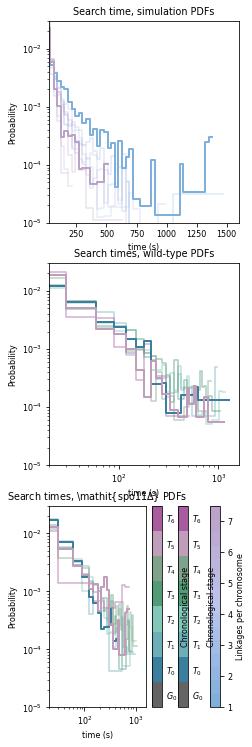

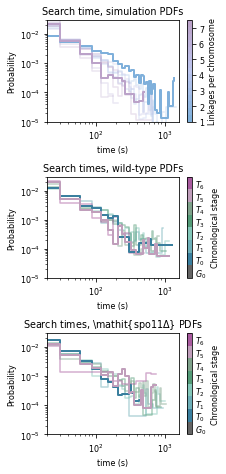

In [126]:
fig7bdf, fig7bdf_heights = bplt.make_at_aspect(
    [fig7b,
     partial(fig7cdef, strain=('LYS2', 'WT'), pair='unpair'), 
     partial(fig7cdef, strain=('LYS2', 'SP'), pair='unpair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
fig7bdf.savefig(output_folder / Path('Fig7bdf.svg'), dpi=300)

they're coming out slightly different sizes, let's do it all at once.

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


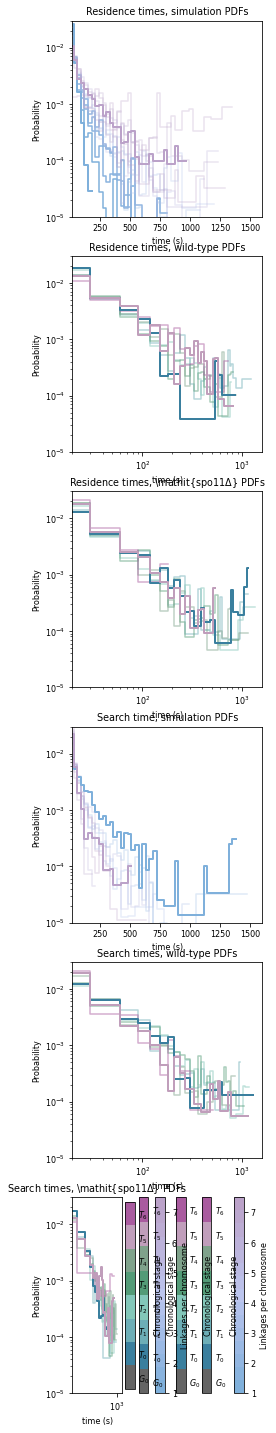

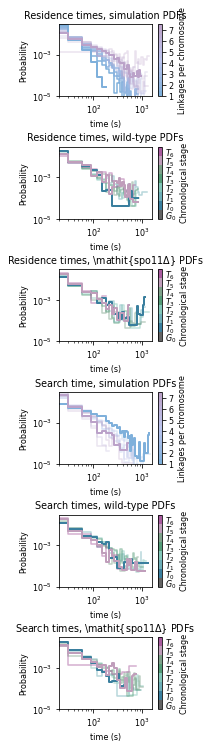

In [127]:
fig7acebdf, fig7acebdf_heights = bplt.make_at_aspect(
    [fig7a,
     partial(fig7cdef, strain=('LYS2', 'WT'), pair='pair'), 
     partial(fig7cdef, strain=('LYS2', 'SP'), pair='pair'),
     fig7b,
     partial(fig7cdef, strain=('LYS2', 'WT'), pair='unpair'), 
     partial(fig7cdef, strain=('LYS2', 'SP'), pair='unpair')],
    6*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=6*['min_axis_width'],
    is_ratio=True
)
fig7acebdf.savefig(output_folder / Path('Fig7acebdf.svg'), dpi=300)

## Supplemental Figure -- Convex Hull of Traj

In [16]:
import multi_locus_analysis.stats

In [18]:
from multi_locus_analysis.stats import convex_hull

In [19]:
chull_volume = burgess.df.groupby(burgess.cell_cols).apply(convex_hull, xcol='X', ycol='Y', zcol='Z', volume=True)

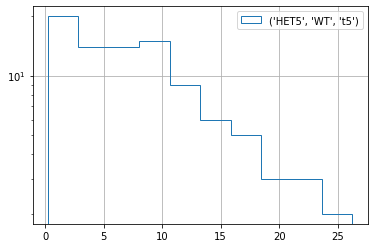

In [20]:
for condition, data in chull_volume.groupby(burgess.condition_cols):
    if condition == ('HET5', 'WT', 't5'):
        data.hist(label=str(condition), histtype='step')
        break
plt.legend()
plt.yscale('log')

In [21]:
def get_chull_volume(df):
    points = df[['X', 'Y', 'Z']].dropna().to_numpy()
    if len(points) == 0:
        return np.nan
    return scipy.spatial.ConvexHull(points).volume
chull_volume = burgess.df.groupby(burgess.cell_cols).apply(get_chull_volume)

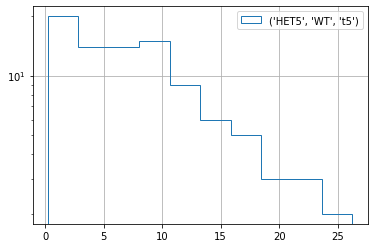

In [22]:
for condition, data in chull_volume.groupby(burgess.condition_cols):
    if condition == ('HET5', 'WT', 't5'):
        data.hist(label=str(condition), histtype='step')
        break
plt.legend()
plt.yscale('log')

In [24]:
chull_volume.loc['HET5', 'WT', :, 't5']

locus  genotype  exp.rep  meiosis  cell
HET5   WT        2        t5       1        7.497403
                                   2       10.503919
                                   3        3.065773
                                   4        4.135349
                                   7       14.163736
                                             ...    
                 3        t5       56       5.942666
                                   57       2.879856
                                   59      21.184126
                                   62      15.348121
                                   63      23.141806
Length: 94, dtype: float64

In [22]:
volume_to_r = lambda V: np.power(3/4/np.pi*V, 1/3)

<AxesSubplot:>

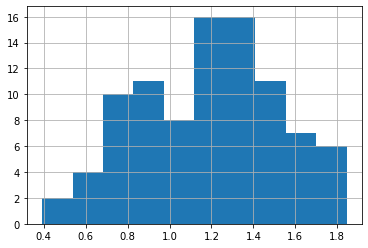

In [27]:
data.apply(volume_to_r).hist()

The volume forumula is 
$(4/3)\pi r^3$, so given the volume, we get $r$ as $((3/4\pi) V)^{1/3}$...

In [19]:
chull_volume.groupby(burgess.condition_cols).mean().apply(lambda V: np.power(3/4/np.pi*V, 1/3))

locus  genotype  meiosis
HET5   WT        t0         0.847339
                 t1         0.950871
                 t2         1.084229
                 t3         1.108406
                 t4         1.275806
                 t5         1.272207
                 ta         1.284811
LYS2   SP        t0         0.680312
                 t1         0.696057
                 t2         0.805385
                 t3         0.874531
                 t4         0.956748
                 t5         0.939411
                 t6         0.958558
       WT        t0         0.852138
                 t1         0.786381
                 t2         0.876471
                 t3         1.105162
                 t4         0.916134
                 t5         1.171249
                 t6         0.952502
URA3   SP        t0         0.794922
                 t1         0.933294
                 t2         1.087284
                 t3         1.142240
                 t4         1.176725
             

So realistically, we will want to call the radius 1.3$\mu{}m$.

## Supplemental Figure -- "Transient" (Un)paired Times

In [12]:
interior_df.head()

start_time  end_time  \
locus genotype exp.rep meiosis cell na_id rank_order                         
HET5  WT       2       t0      10   0     1                   90       180   
                                          2                  180       210   
                                          3                  210       510   
                                          4                  510       540   
                                          5                  540       810   

                                                      wait_time state  \
locus genotype exp.rep meiosis cell na_id rank_order                    
HET5  WT       2       t0      10   0     1                  90   unp   
                                          2                  30  pair   
                                          3                 300   unp   
                                          4                  30  pair   
                                          5                 270   unp   

                                                      min_waits  max_waits  \
locus genotype exp.rep meiosis cell na_id rank_order                         
HET5  WT       2       t0      10   0     1                  60        120   
                                          2                   0         60   
                                          3                 270        330   
                                          4                   0         60   
                                          5                 240        300   

                                                     wait_type  window_size  
locus genotype exp.rep meiosis cell na_id rank_order                         
HET5  WT       2       t0      10   0     1           interior         1470  
                                          2           interior         1470  
                                          3           interior         1470  
                                          4           interior         1470  
                                          5           interior         1470

In [14]:
is_30 = interior_df.reset_index().set_index(['state'] + burgess.condition_cols)
is_30 = is_30['wait_time'] == 30
p30 = is_30.groupby(['state'] + burgess.condition_cols).agg(['mean', 'std', 'count'])
cell_count = interior_df.reset_index().groupby(['state'] + burgess.condition_cols)['cell'].unique().apply(len)
p30['cell_count'] = cell_count
p30['ste'] = p30['std']/np.sqrt(p30['cell_count'])
def suppfig_6a(ax):
    plot_fracs_large(p30.loc['pair'], ax)
    ax.set_title('Fraction of interaction times that are fast')
    return ax
def suppfig_6b(ax):
    plot_fracs_large(p30.loc['unp'], ax)
    ax.set_title('Fraction of search times that are fast')


In [15]:
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = 'k' if genotype == 'WT' else 'r'
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 8  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            
            if ax is None:
                ax = plt
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chron. stage ($t_\#$)')
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  

AttributeError: 'LineCollection' object has no property 'fillstyle'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


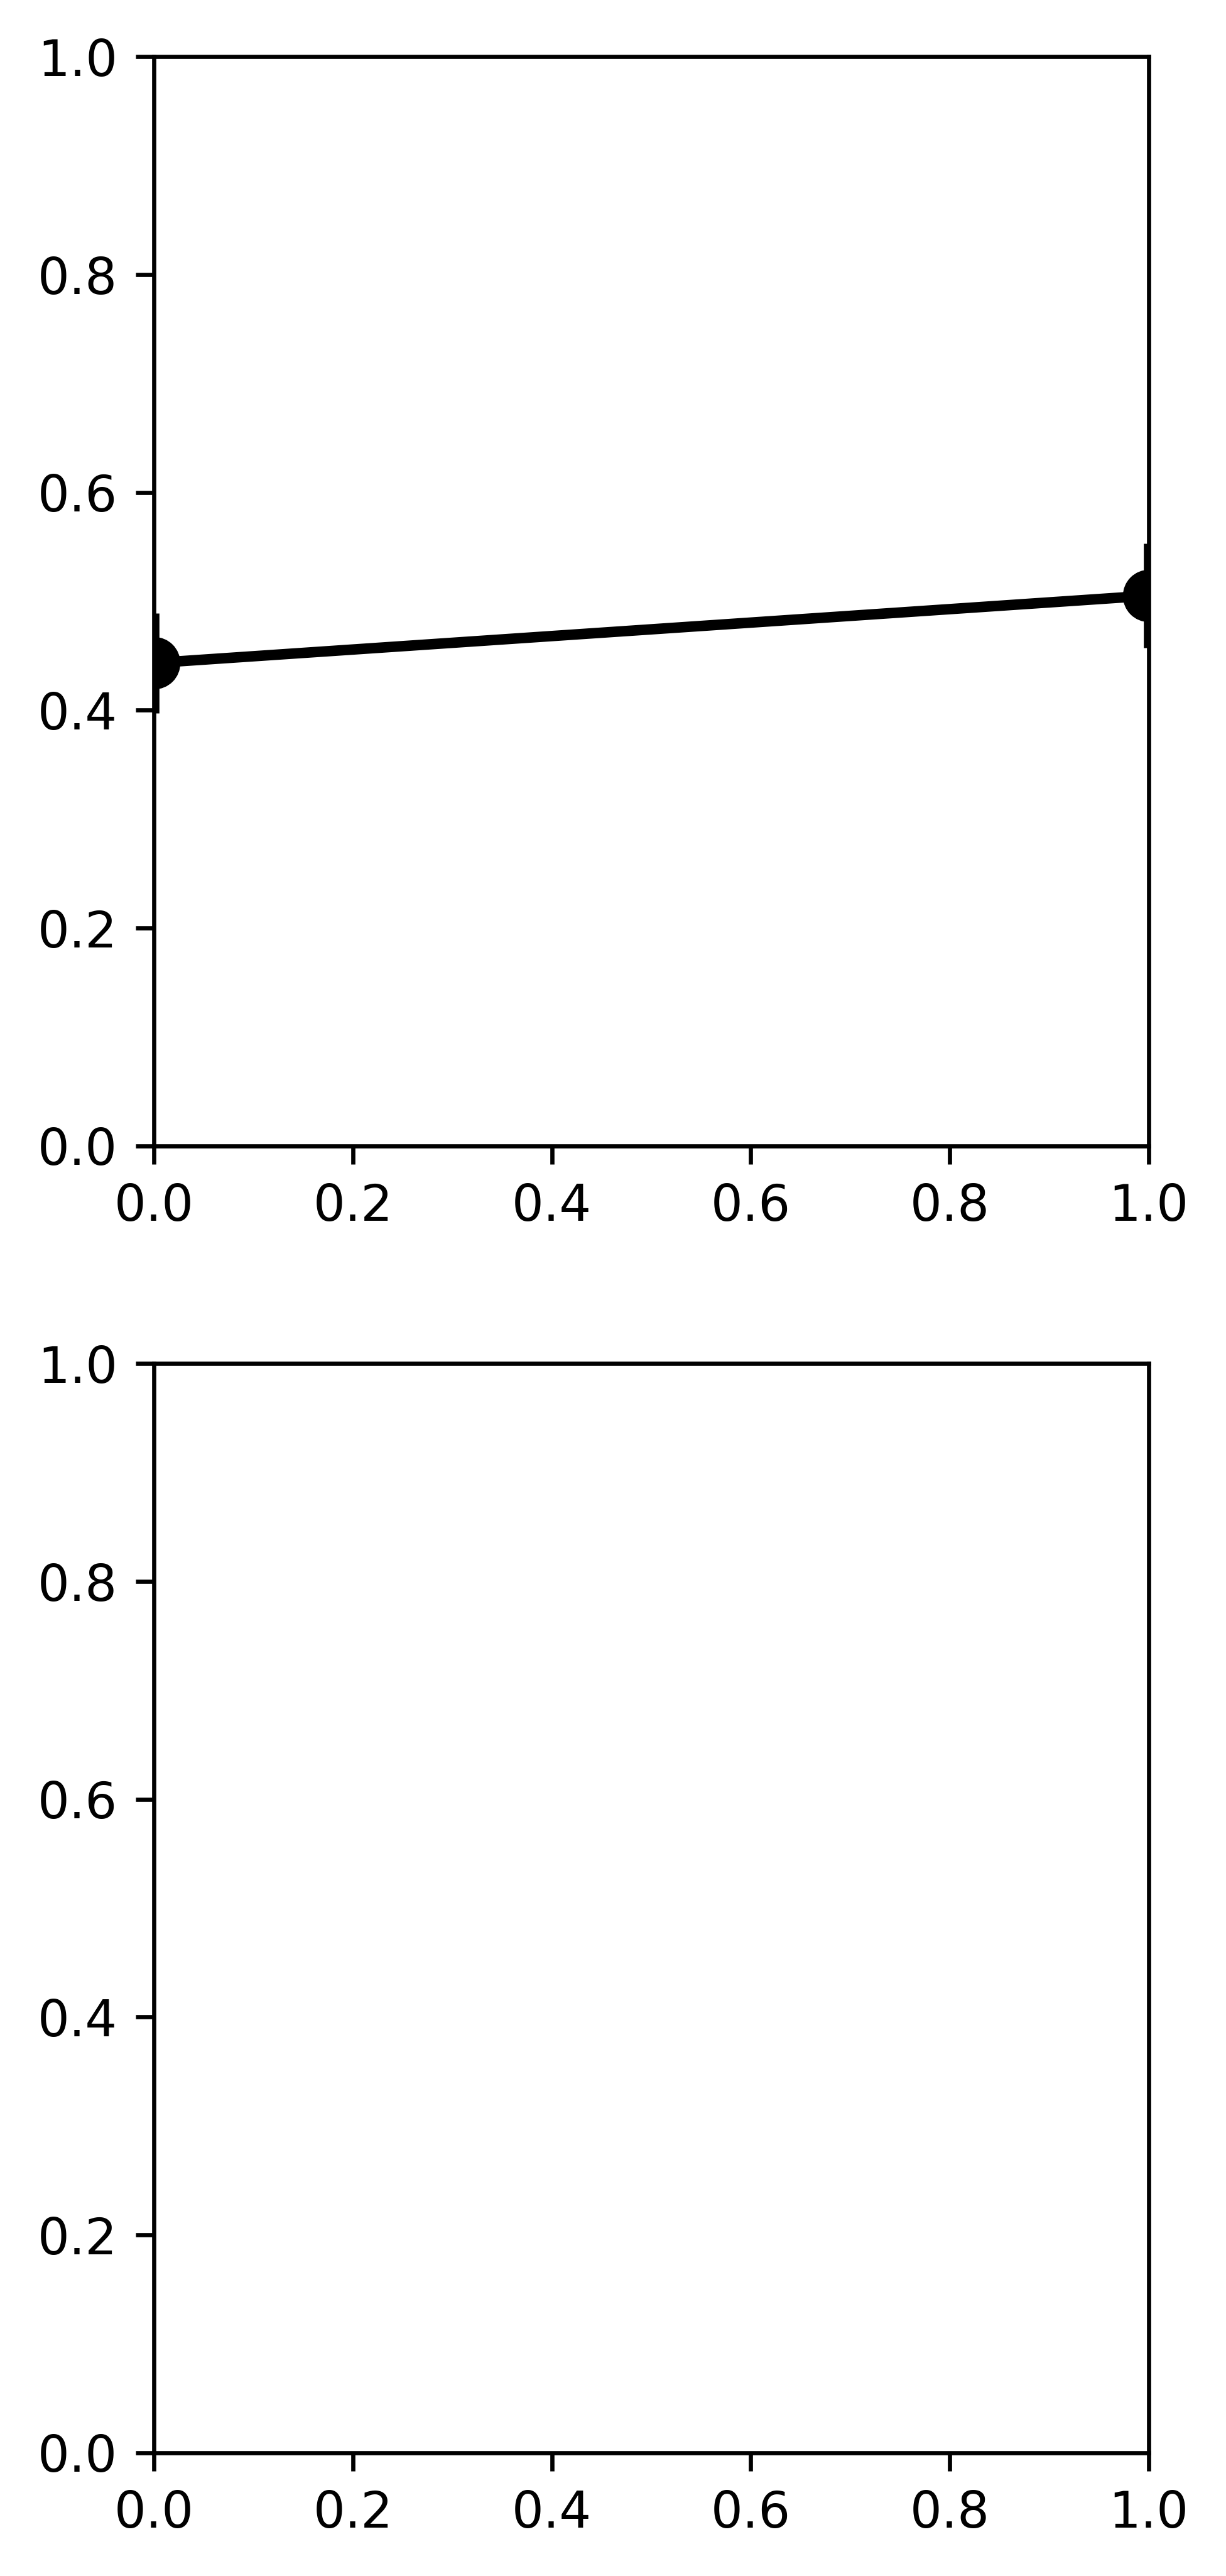

In [16]:
bplt.make_at_aspect([suppfig_6a, suppfig_6b], 2*[1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/SuppFig_p30.svg')

## Chromosome size vs CO count

In [56]:
chr_info = pd.DataFrame([[1, 230218, 2.2],
                         [2, 813184, 6.4],
                         [3, 316620, 3.4],
                         [4, 1531933, 10.2],
                         [5, 576874, 4.45],
                         [6, 270161, 2.65],
                         [7, 1090940, 8.25],
                         [8, 562643, 4.65],
                         [9, 439888, 3],
                         [10, 745751, 6.5],
                         [11, 666816, 5.25],
                         [12, 1078177, 8.65],
                         [13, 924431, 7.25],
                         [14, 784333, 6.4],
                         [15, 1091291, 7.75],
                         [16, 948066, 7.45],
                        ], columns = ['Chromosome', 'Length', 'COs'])

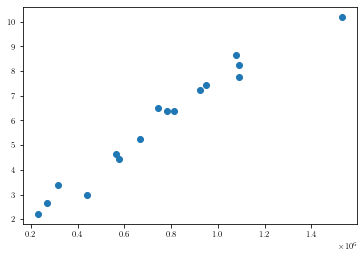

In [57]:
plt.scatter(chr_info['Length'], chr_info['COs'])

## Two particles vs one?

In [35]:
import numpy as np
import pandas as pd
from multi_locus_analysis.stats import pos_to_all_vel
num_time_points = 50
num_polymers = 1000
x = np.random.normal(size=(num_time_points, num_polymers))
x = np.cumsum(x, axis=0)
y = np.random.normal(size=(num_time_points, num_polymers))
y = np.cumsum(y, axis=0)
x = x - y

In [36]:
traj = np.arange(num_polymers)
traj = traj[None, :] + np.zeros_like(x)
t = np.arange(num_time_points)
t = t[:, None] + np.zeros_like(x)

In [37]:
df = pd.DataFrame.from_dict({'x': x.flatten(), 'traj': traj.flatten(), 't': t.flatten()})

In [38]:
vels = df.groupby('traj').apply(pos_to_all_vel, xcol='x', ycol=None, zcol=None, framecol='t')

/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:122: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ti = t[:,None] - np.zeros_like(t)[None,:]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:123: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tf = t[None,:] - np.zeros_like(t)[:,None]
/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/stats.py:129: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  vs = {'v' + col: x[None,:] - x[:,None] for col, x in xs.items()}


In [39]:
vels.groupby('delta')['vx'].apply(lambda S: (S**2).mean())

delta
0.0      0.000000
1.0      1.989816
2.0      3.980748
3.0      5.973168
4.0      7.985148
5.0      9.976294
6.0     11.975873
7.0     13.946765
8.0     15.901597
9.0     17.858970
10.0    19.792084
11.0    21.716648
12.0    23.633833
13.0    25.565717
14.0    27.462708
15.0    29.359628
16.0    31.217277
17.0    33.079429
18.0    34.966311
19.0    36.852112
20.0    38.782620
21.0    40.741036
22.0    42.713619
23.0    44.684574
24.0    46.641450
25.0    48.608876
26.0    50.667845
27.0    52.736930
28.0    54.836439
29.0    56.980073
30.0    59.014881
31.0    61.016676
32.0    63.009342
33.0    65.001347
34.0    66.955974
35.0    68.886405
36.0    70.898552
37.0    72.860550
38.0    74.943092
39.0    76.983795
40.0    79.135038
41.0    81.045724
42.0    82.951621
43.0    84.969815
44.0    86.762573
45.0    88.621200
46.0    90.268609
47.0    91.976269
48.0    93.319416
49.0    95.074069
Name: vx, dtype: float64